In [1]:
import numpy as np
np.random.seed(2342347823)


import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as shc
import matplotlib.pylab as plt
plt.style.use("ggplot") 

from collections import Counter

from scipy import linalg
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import TomekLinks 
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from scipy.sparse import csr_matrix
import json

import sys
sys.setrecursionlimit(10000)

import data_helpers
import data_titles_helpers
from data_helpers import *
from data_titles_helpers import *
import imp
imp.reload(data_helpers)
imp.reload(data_titles_helpers)

<module 'data_titles_helpers' from '/Users/kyrylo/Projects/personal/thesis/data_titles_helpers.py'>

In [2]:
df_se_skills = pd.read_csv(PREPROCESSED_SE_SKILLS_PATH)
df_se_subtracks = pd.read_csv(PREPROCESSED_SE_TRACKS_PATH)

se_skill_names = list(df_se_skills[SKILL_TAG_LABEL])
skill_names = list_mask(df_se_subtracks.columns.to_list(), se_skill_names)
print('Total skills count:', len(skill_names))

track_names = list_mask(skill_names, list(df_se_skills[df_se_skills[IS_TRACK_NAME_LABEL] == True][SKILL_TAG_LABEL]))
skill_names = list_filter(skill_names, track_names)
country_columns = ['COUNTRY_DE','COUNTRY_EE','COUNTRY_FI','COUNTRY_LT','COUNTRY_LV','COUNTRY_PK']
be_skill_names = df_se_skills[SKILL_TAG_LABEL][df_se_skills[IS_BE_LABEL] == True].to_list()
fe_skill_names = df_se_skills[SKILL_TAG_LABEL][df_se_skills[IS_FE_LABEL] == True].to_list()

for skill in skill_names:
    df_se_subtracks[skill] = np.where(df_se_subtracks[skill] > 0, 1 , 0)

df_se_subtracks

Total skills count: 133


ID  TYPE  SENIORITY  \
0      e66911f13061f2226be06c25     0   1.000000   
1      276911f13061f2226be06c25     0   1.000000   
2      e76911f13061f2226be06c25     0   1.000000   
3      f8343b8716ee6a873cfa2dc5     0   1.000000   
4      296911f13061f2226be06c25     0   0.333333   
...                         ...   ...        ...   
40842  6f28bd2100c4c70e6f99cf15     1   1.000000   
40843  de11cc210041983e4a997f35     1   1.000000   
40844  4ee295210002395f262f3ff5     1   1.000000   
40845  dc00042100a3628f746d5f65     1   1.000000   
40846  b512af3031025ea097ad4086     1   0.666667   

                                                   TITLE  COUNTRY_DE  \
0                                              Developer           0   
1                                   Full Stack Developer           0   
2                                Developer, Scrum Master           0   
3                                              Developer           1   
4                                       Junior developer           0   
...                                                  ...         ...   
40842  Senior/Lead SW developer (Backend/Full Stack/AWS)           0   
40843  Experienced Software Developer (Backend/Fronte...           0   
40844                               Senior PHP developer           0   
40845                    Fullstack developer (part-time)           0   
40846        QA Test Automation / JAVA Software Engineer           0   

       COUNTRY_EE  COUNTRY_FI  COUNTRY_LT  COUNTRY_LV  COUNTRY_PK  ...  \
0               1           0           0           0           0  ...   
1               1           0           0           0           0  ...   
2               1           0           0           0           0  ...   
3               0           0           0           0           0  ...   
4               1           0           0           0           0  ...   
...           ...         ...         ...         ...         ...  ...   
40842           0           1           0           0           0  ...   
40843           0           1           0           0           0  ...   
40844           1           0           0           0           0  ...   
40845           1           0           0           0           0  ...   
40846           1           0           0           0           0  ...   

       software_engineering_tool__unity  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   
...                                 ...   
40842                                 0   
40843                                 0   
40844                                 0   
40845                                 0   
40846                                 0   

       software_engineering_tool__unreal_engine  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
...                                         ...   
40842                                         0   
40843                                         0   
40844                                         0   
40845                                         0   
40846                                         0   

       software_engineering_tool__vaadin  software_engineering_tool__vagrant  \
0                                      0                                   0   
1                                      0                                   0   
2                                      0                                   0   
3                                      0                                   0   
4                                      0                                   0   
...                                  ...

# Drop profiles with low # of skills

In [3]:
print('Dropped', df_se_subtracks.loc[df_se_subtracks[skill_names].sum(axis=1) <= 2].shape[0])

df_se_subtracks = df_se_subtracks.loc[df_se_subtracks[skill_names].sum(axis=1) > 2]
df_se_subtracks

Dropped 2737


ID  TYPE  SENIORITY  \
0      e66911f13061f2226be06c25     0   1.000000   
1      276911f13061f2226be06c25     0   1.000000   
2      e76911f13061f2226be06c25     0   1.000000   
3      f8343b8716ee6a873cfa2dc5     0   1.000000   
4      296911f13061f2226be06c25     0   0.333333   
...                         ...   ...        ...   
40842  6f28bd2100c4c70e6f99cf15     1   1.000000   
40843  de11cc210041983e4a997f35     1   1.000000   
40844  4ee295210002395f262f3ff5     1   1.000000   
40845  dc00042100a3628f746d5f65     1   1.000000   
40846  b512af3031025ea097ad4086     1   0.666667   

                                                   TITLE  COUNTRY_DE  \
0                                              Developer           0   
1                                   Full Stack Developer           0   
2                                Developer, Scrum Master           0   
3                                              Developer           1   
4                                       Junior developer           0   
...                                                  ...         ...   
40842  Senior/Lead SW developer (Backend/Full Stack/AWS)           0   
40843  Experienced Software Developer (Backend/Fronte...           0   
40844                               Senior PHP developer           0   
40845                    Fullstack developer (part-time)           0   
40846        QA Test Automation / JAVA Software Engineer           0   

       COUNTRY_EE  COUNTRY_FI  COUNTRY_LT  COUNTRY_LV  COUNTRY_PK  ...  \
0               1           0           0           0           0  ...   
1               1           0           0           0           0  ...   
2               1           0           0           0           0  ...   
3               0           0           0           0           0  ...   
4               1           0           0           0           0  ...   
...           ...         ...         ...         ...         ...  ...   
40842           0           1           0           0           0  ...   
40843           0           1           0           0           0  ...   
40844           1           0           0           0           0  ...   
40845           1           0           0           0           0  ...   
40846           1           0           0           0           0  ...   

       software_engineering_tool__unity  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   
...                                 ...   
40842                                 0   
40843                                 0   
40844                                 0   
40845                                 0   
40846                                 0   

       software_engineering_tool__unreal_engine  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
...                                         ...   
40842                                         0   
40843                                         0   
40844                                         0   
40845                                         0   
40846                                         0   

       software_engineering_tool__vaadin  software_engineering_tool__vagrant  \
0                                      0                                   0   
1                                      0                                   0   
2                                      0                                   0   
3                                      0                                   0   
4                                      0                                   0   
...                                  ...

# Drop minor classes

In [4]:
minor_cluster_names = df_se_subtracks[CLUSTER_LABEL].value_counts().to_frame().query('CLUSTER  < 10').index
rows_from_minro_clasters = df_se_subtracks[CLUSTER_LABEL].isin(minor_cluster_names).to_frame().query('CLUSTER  == True').index

print('Dropped rows:', rows_from_minro_clasters.shape)

df_se_subtracks.drop(rows_from_minro_clasters, inplace=True)
df_se_subtracks.reset_index(drop=True, inplace=True)

df_se_subtracks

Dropped rows: (12834,)


/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ID  TYPE  SENIORITY  \
0      e66911f13061f2226be06c25     0   1.000000   
1      276911f13061f2226be06c25     0   1.000000   
2      e76911f13061f2226be06c25     0   1.000000   
3      f8343b8716ee6a873cfa2dc5     0   1.000000   
4      39108e16d196f7de86bb7c05     0   1.000000   
...                         ...   ...        ...   
25271  dd41b1210012296e07987fc5     1   1.000000   
25272  6f28bd2100c4c70e6f99cf15     1   1.000000   
25273  de11cc210041983e4a997f35     1   1.000000   
25274  dc00042100a3628f746d5f65     1   1.000000   
25275  b512af3031025ea097ad4086     1   0.666667   

                                                   TITLE  COUNTRY_DE  \
0                                              Developer           0   
1                                   Full Stack Developer           0   
2                                Developer, Scrum Master           0   
3                                              Developer           1   
4                                   Senior iOS Developer           0   
...                                                  ...         ...   
25271                    Senior/Lead Mobile SW developer           0   
25272  Senior/Lead SW developer (Backend/Full Stack/AWS)           0   
25273  Experienced Software Developer (Backend/Fronte...           0   
25274                    Fullstack developer (part-time)           0   
25275        QA Test Automation / JAVA Software Engineer           0   

       COUNTRY_EE  COUNTRY_FI  COUNTRY_LT  COUNTRY_LV  COUNTRY_PK  ...  \
0               1           0           0           0           0  ...   
1               1           0           0           0           0  ...   
2               1           0           0           0           0  ...   
3               0           0           0           0           0  ...   
4               1           0           0           0           0  ...   
...           ...         ...         ...         ...         ...  ...   
25271           0           1           0           0           0  ...   
25272           0           1           0           0           0  ...   
25273           0           1           0           0           0  ...   
25274           1           0           0           0           0  ...   
25275           1           0           0           0           0  ...   

       software_engineering_tool__unity  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     1   
...                                 ...   
25271                                 0   
25272                                 0   
25273                                 0   
25274                                 0   
25275                                 0   

       software_engineering_tool__unreal_engine  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
...                                         ...   
25271                                         0   
25272                                         0   
25273                                         0   
25274                                         0   
25275                                         0   

       software_engineering_tool__vaadin  software_engineering_tool__vagrant  \
0                                      0                                   0   
1                                      0                                   0   
2                                      0                                   0   
3                                      0                                   0   
4                                      0                                   0   
...                                  ...

## Test / Train splitting 

In [5]:
X_columns = [*skill_names, *track_names, *country_columns]

X_train, X_val = train_test_split(df_se_subtracks[X_columns], test_size=0.3, random_state=0, stratify=df_se_subtracks['CLUSTER'])
# X_train, X_val = train_test_split(df_se_subtracks[X_columns], test_size=0.4, random_state=0, stratify=df_se_subtracks['CLUSTER'])
# X_train, X_val = train_test_split(df_se_subtracks[X_columns], test_size=0.25, random_state=0)

features_set = list(df_se_subtracks[skill_names].sum().sort_values(ascending=False).nlargest(30).index)
# features_set = df_se_subtracks[[*skill_names]].sum().sort_values(ascending=False).index # slills by # of profiles
# features_set = df_se_subtracks[skill_names].sum().sort_values(ascending=False).nlargest(30).index # slills by # of profiles
# features_set = ['programming_language__java', 'programming_language__javascript', 'programming_language__csharp', 'programming_language__php', 'programming_language__python']
for feature in features_set:
    print(feature)

print(X_train.shape, X_val.shape)

programming_language__javascript
programming_language__html_css
software_engineering_tool__rest_api
programming_language__sql
programming_language__java
software_engineering_tool__react
software_engineering_tool__mysql
software_engineering_tool__nodejs
programming_language__php
software_engineering_tool__linux
programming_language__csharp
software_engineering_tool__jquery
programming_language__typescript
software_engineering_tool__windows
software_engineering_tool__docker
software_engineering_tool__spring
software_engineering_tool__angular
software_engineering_tool__postgresql
programming_language__python
software_engineering_tool__asp_net
software_engineering_tool__aws
software_engineering_tool__hibernate
software_engineering_tool__vuejs
software_engineering_tool__jenkins
software_engineering_tool__mongodb
software_engineering_tool__laravel
software_engineering_tool__express
programming_language__c_cpp
software_engineering_tool__android_native
software_engineering_tool__react_native
(

In [6]:
_X_train = pd.DataFrame(columns=X_train.columns)
_y_train = np.array([])

_X_val = pd.DataFrame(columns=X_train.columns)
_y_val = np.array([])

for skill in features_set:
    X_train_for_skill = X_train.loc[X_train[skill] > 0].copy()
    X_train_for_skill[skill] = 0 
    _X_train = _X_train.append(X_train_for_skill)
    
    y_train_for_skill = np.repeat(skill, X_train_for_skill.shape[0])
    _y_train = np.append(_y_train, y_train_for_skill)
    
    X_val_for_skill = X_val.loc[X_val[skill]>0].copy()
    X_val_for_skill[skill] = 0
    _X_val = _X_val.append(X_val_for_skill)
    
    y_val_for_skill = np.repeat(skill, X_val_for_skill.shape[0])
    _y_val = np.append(_y_val, y_val_for_skill)
    
    
_X_train.reset_index(drop=True, inplace=True)
_X_train.drop_duplicates(inplace=True)
_y_train = _y_train[_X_train.index]
_X_train.reset_index(drop=True, inplace=True)

_X_val.reset_index(drop=True, inplace=True)


    
print('Train:', _X_train.shape, _y_train.shape, 'Val:', _X_val.shape, _y_val.shape)

Train: (75113, 139) (75113,) Val: (42332, 139) (42332,)


<AxesSubplot:>

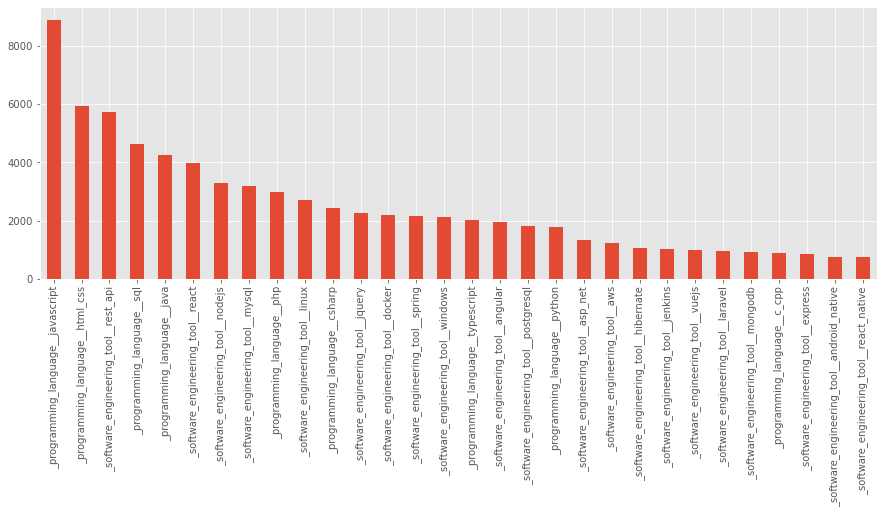

In [7]:
pd.get_dummies(pd.DataFrame(_y_train), prefix='').sum().sort_values(ascending=False).plot(kind='bar', figsize=(15,5))

In [8]:
save_train_x = _X_train.copy()
save_train_y = _y_train.copy()

save_val_x = _X_val.copy()
save_val_y = _y_val.copy()

In [21]:
_X_train = save_train_x.copy()
_y_train = save_train_y.copy()

_X_val = save_val_x.copy()
_y_val = save_val_y.copy()

In [10]:
print(save_train_x.shape, save_train_y.shape)

top_classes = list(save_train_x[features_set].sum().loc[save_train_x[features_set].sum().sort_values() > 2000].index)
sizes = np.repeat(2000, len(top_classes)) 
sizes_map = dict(zip(top_classes, sizes))

tomek = TomekLinks(n_jobs=15, sampling_strategy=top_classes)
_X_train, _y_train = tomek.fit_sample(save_train_x, save_train_y)

print(_X_train.shape, _y_train.shape)
play_sound()

(75113, 139) (75113,)
(59453, 139) (59453,)


In [11]:
# print(_X_train.shape, _y_train.shape)
# pass

# top_classes = list(X_train[features_set].sum().loc[X_train[features_set].sum().sort_values() < 2000].index)
# sizes = np.repeat(2000, len(top_classes)) 

# smoteeen = SMOTETomek(n_jobs=15, sampling_strategy=dict(zip(top_classes, sizes)), random_state=0)
# _X_train, _y_train = smoteeen.fit_sample(_X_train, _y_train)

# print(_X_train.shape, _y_train.shape)

# smt = SMOTETomek(smote=smote, tomek=tomek, random_state=0)
# _X_train, _y_train = smt.fit_sample(_X_train, _y_train)

print(_X_train.shape, _y_train.shape)

(59453, 139) (59453,)


<AxesSubplot:>

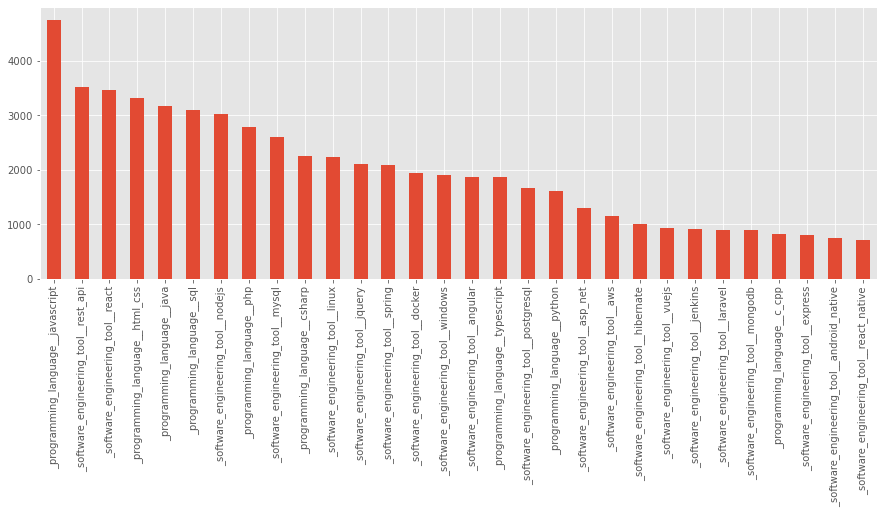

In [12]:
pd.get_dummies(pd.DataFrame(_y_train), prefix='').sum().sort_values(ascending=False).plot(kind='bar', figsize=(15,5))

In [22]:
_X_train_ = _X_train.copy()
_X_train_['y'] = _y_train.copy()

_X_train_ = _X_train_.groupby('y', group_keys=False).apply(lambda x: x.sample(min(len(x), 2000)))
_y_train_ = _X_train_['y']
_X_train_.drop(columns=['y'], inplace=True)
_X_train_.shape

(48360, 139)

In [14]:
# tf_idf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
# tf_idf_transformer.fit(_X_train[[*skill_names, *track_names]])


# tf_idf = tf_idf_transformer.transform(_X_train[[*skill_names, *track_names]])
# tf_idf = pd.DataFrame.sparse.from_spmatrix(tf_idf)
# tf_idf.columns = [*skill_names, *track_names]
# tf_idf

# _X_train = pd.concat([_X_train.drop(columns = [*skill_names, *track_names]), tf_idf], axis=1).dropna()


# tf_idf = tf_idf_transformer.transform(_X_val[[*skill_names, *track_names]])
# tf_idf = pd.DataFrame.sparse.from_spmatrix(tf_idf)
# tf_idf.columns = [*skill_names, *track_names]
# tf_idf

# _X_val = pd.concat([_X_val.drop(columns = [*skill_names, *track_names]), tf_idf], axis=1).dropna()

In [41]:
def mmr_score(expected, predicted_list, n):
    target_list = predicted_list[:n]
    
    if expected in target_list:
        return 1 / (target_list.index(expected) + 1)
    
    if (len(target_list) < n):
        print('Not enough samples')
        
    return 0

## Multilabel fit

In [42]:
classifier = OneVsRestClassifier(MultinomialNB(alpha=0.1, fit_prior=True, class_prior=None))
classifier.fit(_X_train, _y_train)

# y_pred = classifier.predict(_X_val)

mmr_scores_10 = []
mmr_scores_5 = []
mmr_scores_3 = []
y_pred = []

predictions = classifier.predict_proba(_X_val)
for ix, profile in _X_val.iterrows():
    profile_predictions = predictions[ix]

    skills_already_in_profile = [list(classifier.classes_).index(index) for index in  profile[classifier.classes_][profile>0].index.to_list()]
    for index in skills_already_in_profile:
        profile_predictions[index] = 0

    ordered_predictions = profile_predictions.argsort()[::-1]
    result = classifier.classes_[ordered_predictions[0]]
    
    mmr_scores_10.append(mmr_score(_y_val[ix], [classifier.classes_[x] for x in ordered_predictions], 10))
    mmr_scores_5.append(mmr_score(_y_val[ix], [classifier.classes_[x] for x in ordered_predictions], 5))
    mmr_scores_3.append(mmr_score(_y_val[ix], [classifier.classes_[x] for x in ordered_predictions], 3))

    y_pred.append(result)

    sys.stdout.write("\r Profile " + str(ix + 1) + '/' + str(_X_val.shape[0]))
    sys.stdout.flush() 

play_sound()

 Profile 42332/42332

acc 0.4110129452896154
recall 0.4110129452896154
precesion 0.4431764743953003
f1 0.4151016365118675
MRR_10 0.569757933883182
MRR_5 0.5513114586286182
MRR_3 0.5237212195659705


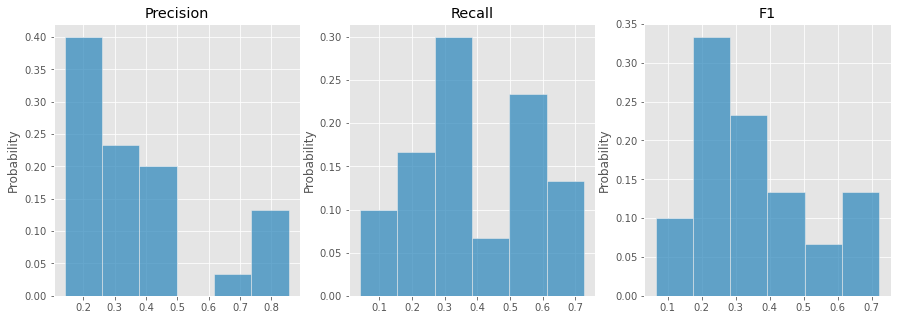

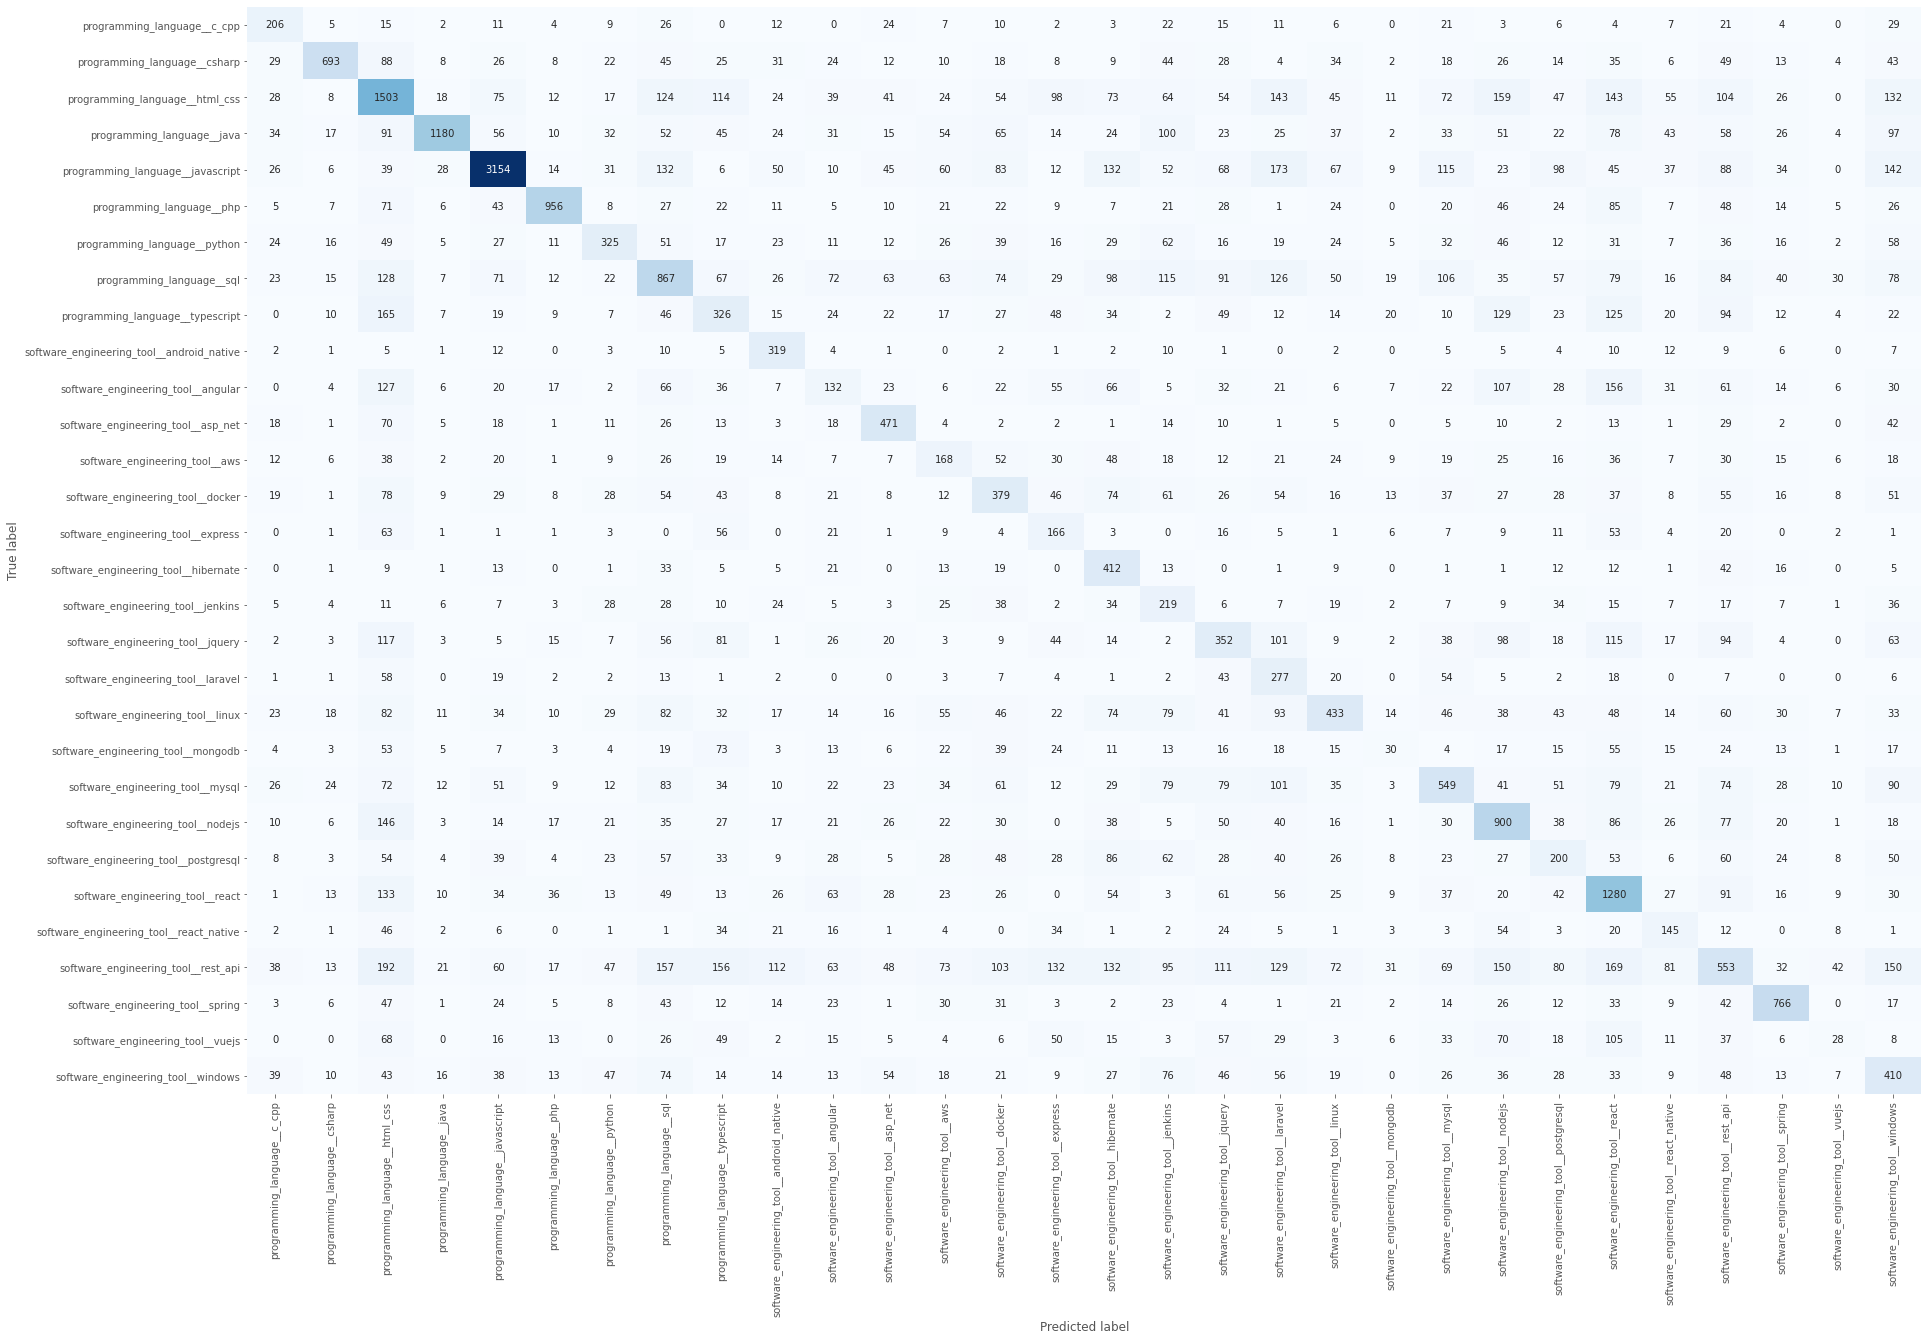

In [43]:
def display_scores(actual, pred):
    print('acc', accuracy_score(actual, pred))
    print('recall', recall_score(actual, pred, average = "weighted"))
    print('precesion', precision_score(actual, pred, average = "weighted"))
    print('f1', f1_score(actual, pred, average = "weighted"))
    print('MRR_10', np.mean(mmr_scores_10))
    print('MRR_5', np.mean(mmr_scores_5))
    print('MRR_3', np.mean(mmr_scores_3))
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))
    sns.histplot(precision_score(actual, pred, average = None), stat='probability', ax=ax1).set(title='Precision')
    sns.histplot(recall_score(actual, pred, average = None), stat='probability', ax=ax2).set(title='Recall')
    sns.histplot(f1_score(actual, pred, average = None), stat='probability', ax=ax3).set(title='F1')
    plt.show()

display_scores(_y_val, y_pred)

make_confusion_matrix(confusion_matrix(_y_val, y_pred), figsize=(30,20), 
                      count=True,
                      percent=False,
                      sum_stats=False,
                      categories=classifier.classes_, cbar=False)


# acc 0.4100916564301238
# recall 0.4100916564301238
# precesion 0.44285501375701863
# f1 0.4141399302468857

In [17]:
X_val.loc[(X_val[skill_names].sum(axis=1) == 3) & (X_val['programming_language__javascript'] == 1)]

programming_language__bash  programming_language__c_cpp  \
13804                           0                            0   
22111                           0                            0   
1092                            0                            0   
19449                           0                            0   
4019                            0                            0   
...                           ...                          ...   
16128                           0                            0   
16278                           0                            0   
22522                           0                            0   
14946                           0                            0   
18681                           0                            0   

       programming_language__clojure  programming_language__csharp  \
13804                              0                             0   
22111                              0                             0   
1092                               0                             0   
19449                              0                             0   
4019                               0                             0   
...                              ...                           ...   
16128                              0                             0   
16278                              0                             0   
22522                              0                             0   
14946                              0                             0   
18681                              0                             0   

       programming_language__dart  programming_language__elixir  \
13804                           0                             0   
22111                           0                             0   
1092                            0                             0   
19449                           0                             0   
4019                            0                             0   
...                           ...                           ...   
16128                           0                             0   
16278                           0                             0   
22522                           0                             0   
14946                           0                             0   
18681                           0                             0   

       programming_language__erlang  programming_language__fsharp  \
13804                             0                             0   
22111                             0                             0   
1092                              0                             0   
19449                             0                             0   
4019                              0                             0   
...                             ...                           ...   
16128                             0                             0   
16278                             0                             0   
22522                             0                             0   
14946                             0                             0   
18681                             0                             0   

       programming_language__golang  programming_language__groovy  ...  \
13804                             0                             0  ...   
22111                             0                             0  ...   
1092                              0                             0  ...   
19449                             0                             0  ...   
4019                              0                             0  ...   
...                             ...                           ...  ...   
16128                             0                             0  ...   
16278                             0                             0  ...   
22522                             0                             0  ...   

In [18]:
X_val[(X_val[[*skill_names, *track_names]].sum(axis=1) == 4) & (X_val['software_engineering__backend_development'] > 0)]

programming_language__bash  programming_language__c_cpp  \
20856                           0                            0   
22504                           0                            0   
17626                           0                            0   
22079                           0                            0   
17518                           0                            0   
...                           ...                          ...   
15076                           0                            0   
10643                           0                            0   
10241                           0                            0   
23457                           0                            0   
16665                           0                            0   

       programming_language__clojure  programming_language__csharp  \
20856                              0                             1   
22504                              0                             1   
17626                              0                             0   
22079                              0                             0   
17518                              0                             1   
...                              ...                           ...   
15076                              0                             1   
10643                              0                             0   
10241                              0                             0   
23457                              0                             0   
16665                              0                             0   

       programming_language__dart  programming_language__elixir  \
20856                           0                             0   
22504                           0                             0   
17626                           0                             0   
22079                           0                             0   
17518                           0                             0   
...                           ...                           ...   
15076                           0                             0   
10643                           0                             0   
10241                           0                             0   
23457                           0                             0   
16665                           0                             0   

       programming_language__erlang  programming_language__fsharp  \
20856                             0                             0   
22504                             0                             0   
17626                             0                             0   
22079                             0                             0   
17518                             0                             0   
...                             ...                           ...   
15076                             0                             0   
10643                             0                             0   
10241                             0                             0   
23457                             0                             0   
16665                             0                             0   

       programming_language__golang  programming_language__groovy  ...  \
20856                             0                             0  ...   
22504                             0                             0  ...   
17626                             0                             0  ...   
22079                             0                             0  ...   
17518                             0                             0  ...   
...                             ...                           ...  ...   
15076                             0                             0  ...   
10643                             0                             0  ...   
10241                             0                             0  ...   

In [19]:
X_val.columns

Index(['programming_language__bash', 'programming_language__c_cpp',
       'programming_language__clojure', 'programming_language__csharp',
       'programming_language__dart', 'programming_language__elixir',
       'programming_language__erlang', 'programming_language__fsharp',
       'programming_language__golang', 'programming_language__groovy',
       ...
       'software_engineering__robotic_process_automation',
       'software_engineering__security_engineering',
       'software_engineering__systems_analysis',
       'software_engineering__systems_architecture', 'COUNTRY_DE',
       'COUNTRY_EE', 'COUNTRY_FI', 'COUNTRY_LT', 'COUNTRY_LV', 'COUNTRY_PK'],
      dtype='object', length=139)

In [20]:
def create_profile(tags):
    profile = X_train.iloc[0].copy().to_frame().T.reset_index(drop=True);
    profile.iloc[0] = 0
    
    for tag in tags:
        profile[tag] = 1
        
    return profile.iloc[0]

test_profile = create_profile(['COUNTRY_EE', 'programming_language__java',
       'software_engineering_tool__linux',
       'software_engineering_tool__windows',
       'software_engineering__backend_development',
       'software_engineering__full_stack_development'])

print('Profile:', test_profile[[*track_names, *skill_names]][test_profile>0].to_frame(), '\n')

predictions = classifier.predict_proba([test_profile])[0]
skills_already_in_profile = [list(classifier.classes_).index(index) for index in list_mask(test_profile[skill_names][test_profile>0].index, features_set)]
for index in skills_already_in_profile:
    predictions[index] = 0

print('Reccomendations:')
for index in predictions.argsort()[::-1]:
    print(classifier.classes_[index])


    


Profile:                                                 0
software_engineering__backend_development     1.0
software_engineering__full_stack_development  1.0
programming_language__java                    1.0
software_engineering_tool__linux              1.0
software_engineering_tool__windows            1.0 

Reccomendations:
software_engineering_tool__spring
programming_language__sql
software_engineering_tool__hibernate
software_engineering_tool__mysql
programming_language__python
software_engineering_tool__docker
software_engineering_tool__postgresql
programming_language__c_cpp
software_engineering_tool__rest_api
software_engineering_tool__jenkins
programming_language__javascript
programming_language__csharp
programming_language__php
programming_language__html_css
software_engineering_tool__aws
software_engineering_tool__jquery
software_engineering_tool__angular
software_engineering_tool__android_native
software_engineering_tool__asp_net
software_engineering_tool__nodejs
software_eng